#1. Prepare the environment

In [ ]:
# List all NVIDIA GPUs as available in this computer (or Colab's session)
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-09744e42-eae9-e27d-ae5f-23352bcafce6)


In [ ]:
import sys
print( f"Python {sys.version}\n" )

import numpy as np
print( f"NumPy {np.__version__}\n" )

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
print( f"Matplotlib {matplotlib.__version__}\n" )

import tensorflow as tf
print( f"TensorFlow {tf.__version__}" )
print( f"tf.keras.backend.image_data_format() = {tf.keras.backend.image_data_format()}" )

# Count the number of GPUs as detected by tensorflow
gpus = tf.config.list_physical_devices('GPU')
print( f"TensorFlow detected { len(gpus) } GPU(s):" )
for i, gpu in enumerate(gpus):
  print( f".... GPU No. {i}: Name = {gpu.name} , Type = {gpu.device_type}" )

import cv2

Python 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]

NumPy 1.25.2

Matplotlib 3.7.1

TensorFlow 2.15.0
tf.keras.backend.image_data_format() = channels_last
TensorFlow detected 1 GPU(s):
.... GPU No. 0: Name = /physical_device:GPU:0 , Type = GPU


In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD
import os
import itertools
from PIL import Image
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, mean_squared_error

#2. Load the Datasets

In [ ]:
# Set fixed seeding values for reproducability during experiments
# Skip this cell if random initialization (with varied results) is needed
# np.random.seed(1234)
# tf.random.set_seed(5678)

In [ ]:
# Step 1: Clone the repository
!git clone https://github.com/y-lims/DADS7203_ThaiAlphabet_Homework.git

# Define the paths to the image folders
base_path = '/content/DADS7203_ThaiAlphabet_Homework'
image_folders = [
    os.path.join(base_path, 'ค'),
    os.path.join(base_path, 'ฅ'),
    os.path.join(base_path, 'ด'),
    os.path.join(base_path, 'ต'),
    os.path.join(base_path, 'ศ')
]

Cloning into 'DADS7203_ThaiAlphabet_Homework'...
remote: Enumerating objects: 1945, done.
remote: Counting objects: 100% (1945/1945), done.
remote: Compressing objects: 100% (1943/1943), done.
remote: Total 1945 (delta 53), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (1945/1945), 4.11 MiB | 13.71 MiB/s, done.
Resolving deltas: 100% (53/53), done.


In [ ]:
# Initialize a list to hold all image data
all_images = []
all_labels = []

# Define the image size
img_w, img_h = 224, 224

# Process each folder
for idx, folder in enumerate(image_folders):
    print(f"Processing folder: {folder}")

    # List all files in the folder and label class
    images = [f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]

    # Load each image in the folder
    for image_name in images:
        image_path = os.path.join(folder, image_name)

        # Use PIL to open and resize the image
        try:
            image = Image.open(image_path).convert('RGB')  # Convert to RGB if necessary
            image = image.resize((224, 224))  # Resize image to 224x224
            all_images.append(np.array(image))
            all_labels.append(idx)  # Use the folder index as the label
        except Exception as e:
            print(f"Skipping image {image_name} due to error: {str(e)}")

# Convert lists to numpy arrays
all_images = np.array(all_images)
all_labels = np.array(all_labels)

print(f"Collected {len(all_images)} images.")
print(f"Collected labels: {set(all_labels)}")

Processing folder: /content/DADS7203_ThaiAlphabet_Homework/ค
Processing folder: /content/DADS7203_ThaiAlphabet_Homework/ฅ
Processing folder: /content/DADS7203_ThaiAlphabet_Homework/ด
Processing folder: /content/DADS7203_ThaiAlphabet_Homework/ต
Processing folder: /content/DADS7203_ThaiAlphabet_Homework/ศ
Collected 1852 images.
Collected labels: {0, 1, 2, 3, 4}


#3. Load VGG-16 model

In [ ]:
vgg_extractor = tf.keras.applications.VGG16(weights='imagenet',
                                            include_top=False,
                                            input_shape=(img_w, img_h, 3))

vgg_extractor.summary()

58889256/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(all_images, all_labels, test_size=0.2, random_state=42)

# Check shapes and types
print(f"x_train: type={type(x_train)} , dtype={x_train.dtype} , shape={x_train.shape} , min={x_train.min(axis=None)} , max={x_train.max(axis=None)}")
print(f"y_train: type={type(y_train)} , dtype={y_train.dtype} , shape={y_train.shape} , min={min(y_train)} , max={max(y_train)}")
print(f"x_test: type={type(x_test)} , dtype={x_test.dtype} , shape={x_test.shape} , min={x_test.min(axis=None)} , max={x_test.max(axis=None)}")
print(f"y_test: type={type(y_test)} , dtype={y_test.dtype} , shape={y_test.shape} , min={min(y_test)} , max={max(y_test)}")

x_train: type=<class 'numpy.ndarray'> , dtype=uint8 , shape=(1481, 224, 224, 3) , min=0 , max=255
y_train: type=<class 'numpy.ndarray'> , dtype=int64 , shape=(1481,) , min=0 , max=4
x_test: type=<class 'numpy.ndarray'> , dtype=uint8 , shape=(371, 224, 224, 3) , min=0 , max=255
y_test: type=<class 'numpy.ndarray'> , dtype=int64 , shape=(371,) , min=0 , max=4


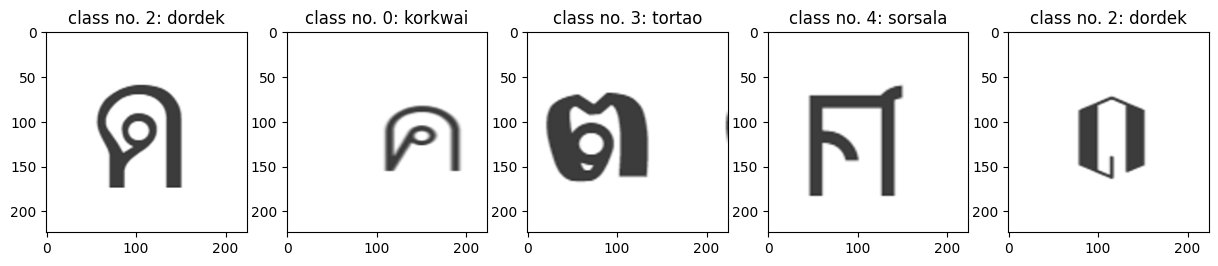

In [ ]:
collected_labels = ['korkwai', 'korkon', 'dordek', 'tortao', 'sorsala']

# Visualize the first five images in x_train
plt.figure(figsize=(15, 5))
for i in range(5):
    class_index = y_train[i]
    class_label = collected_labels[class_index]

    plt.subplot(150 + 1 + i).set_title(f"class no. {class_index}: {class_label}")
    plt.imshow(x_train[i])
plt.show()

In [ ]:
# Preprocess dataset to match VGG-16's requirements
x_train_vgg = tf.keras.applications.vgg16.preprocess_input(x_train)
x_test_vgg = tf.keras.applications.vgg16.preprocess_input(x_test)

print( x_train_vgg.dtype, x_train_vgg.shape, np.min(x_train_vgg), np.max(x_train_vgg) )
print( x_test_vgg.dtype, x_test_vgg.shape, np.min(x_test_vgg), np.max(x_test_vgg) )

float32 (1481, 224, 224, 3) -123.68 151.061
float32 (371, 224, 224, 3) -123.68 151.061


#5. Prepare for transfer learning and finetuning

Access and freeze layer(s) in Keras's model

In [ ]:
# Iterate over all layers in the model
for i,layer in enumerate(vgg_extractor.layers):
    print( f"Layer {i}: name = {layer.name} , trainable = {layer.trainable}" )

Layer 0: name = input_1 , trainable = True
Layer 1: name = block1_conv1 , trainable = True
Layer 2: name = block1_conv2 , trainable = True
Layer 3: name = block1_pool , trainable = True
Layer 4: name = block2_conv1 , trainable = True
Layer 5: name = block2_conv2 , trainable = True
Layer 6: name = block2_pool , trainable = True
Layer 7: name = block3_conv1 , trainable = True
Layer 8: name = block3_conv2 , trainable = True
Layer 9: name = block3_conv3 , trainable = True
Layer 10: name = block3_pool , trainable = True
Layer 11: name = block4_conv1 , trainable = True
Layer 12: name = block4_conv2 , trainable = True
Layer 13: name = block4_conv3 , trainable = True
Layer 14: name = block4_pool , trainable = True
Layer 15: name = block5_conv1 , trainable = True
Layer 16: name = block5_conv2 , trainable = True
Layer 17: name = block5_conv3 , trainable = True
Layer 18: name = block5_pool , trainable = True


In [ ]:
# Freeze all layers in the model
vgg_extractor.trainable = False

for i,layer in enumerate(vgg_extractor.layers):
    print( f"Layer {i}: name = {layer.name} , trainable = {layer.trainable}" )

Layer 0: name = input_1 , trainable = False
Layer 1: name = block1_conv1 , trainable = False
Layer 2: name = block1_conv2 , trainable = False
Layer 3: name = block1_pool , trainable = False
Layer 4: name = block2_conv1 , trainable = False
Layer 5: name = block2_conv2 , trainable = False
Layer 6: name = block2_pool , trainable = False
Layer 7: name = block3_conv1 , trainable = False
Layer 8: name = block3_conv2 , trainable = False
Layer 9: name = block3_conv3 , trainable = False
Layer 10: name = block3_pool , trainable = False
Layer 11: name = block4_conv1 , trainable = False
Layer 12: name = block4_conv2 , trainable = False
Layer 13: name = block4_conv3 , trainable = False
Layer 14: name = block4_pool , trainable = False
Layer 15: name = block5_conv1 , trainable = False
Layer 16: name = block5_conv2 , trainable = False
Layer 17: name = block5_conv3 , trainable = False
Layer 18: name = block5_pool , trainable = False


#6. Add a new classification head

In [ ]:
x = vgg_extractor.output

# Extract features from VGG and # Add classification layer
x = vgg_extractor.output
x = tf.keras.layers.Flatten()(vgg_extractor.output)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.25)(x)

outputs = tf.keras.layers.Dense(5, activation='softmax')(x)# Assuming 5 classes: ด, ต, ค, ศ, ฅ

# Construct the main model
model = tf.keras.models.Model(inputs=vgg_extractor.input, outputs=outputs)

# Display the model summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

#7. Train the model

In [ ]:
# Compile the model
model.compile( loss="sparse_categorical_crossentropy",
              optimizer="adam",
               metrics=["acc"] )

# Print model summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
# Set epochs=5
history = model.fit( x_train_vgg, y_train,
                    batch_size=128, epochs=5,
                    verbose=1, validation_split=0.2)

Epoch 1/5
10/10 [==============================] - 42s 2s/step - loss: 29.1043 - acc: 0.3209 - val_loss: 4.2849 - val_acc: 0.4545
Epoch 2/5
10/10 [==============================] - 5s 541ms/step - loss: 1.9796 - acc: 0.5591 - val_loss: 1.2542 - val_acc: 0.6027
Epoch 3/5
10/10 [==============================] - 5s 524ms/step - loss: 0.8729 - acc: 0.6917 - val_loss: 1.0014 - val_acc: 0.5993
Epoch 4/5
10/10 [==============================] - 5s 553ms/step - loss: 0.5929 - acc: 0.7762 - val_loss: 0.8957 - val_acc: 0.6263
Epoch 5/5
10/10 [==============================] - 5s 544ms/step - loss: 0.4007 - acc: 0.8564 - val_loss: 0.8611 - val_acc: 0.6835


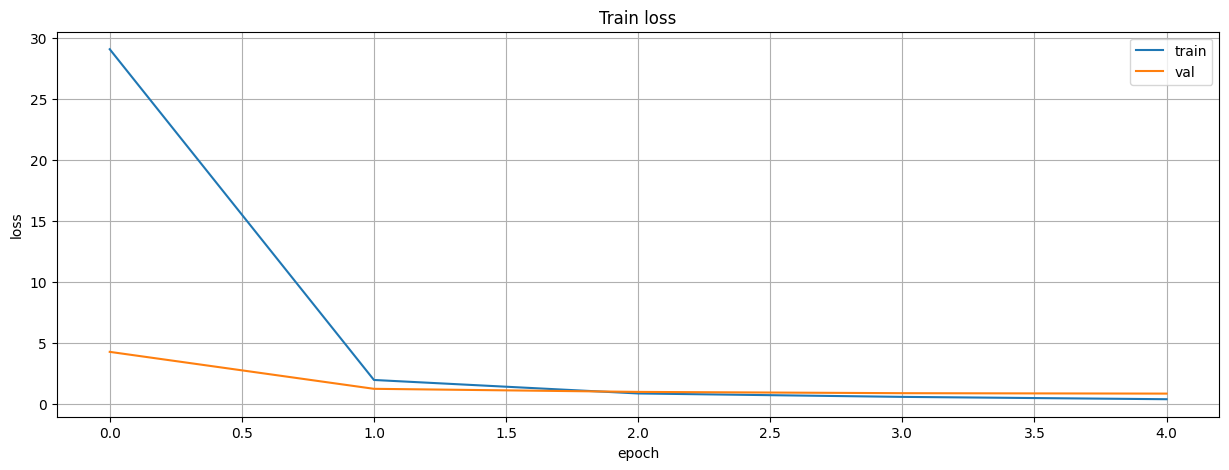

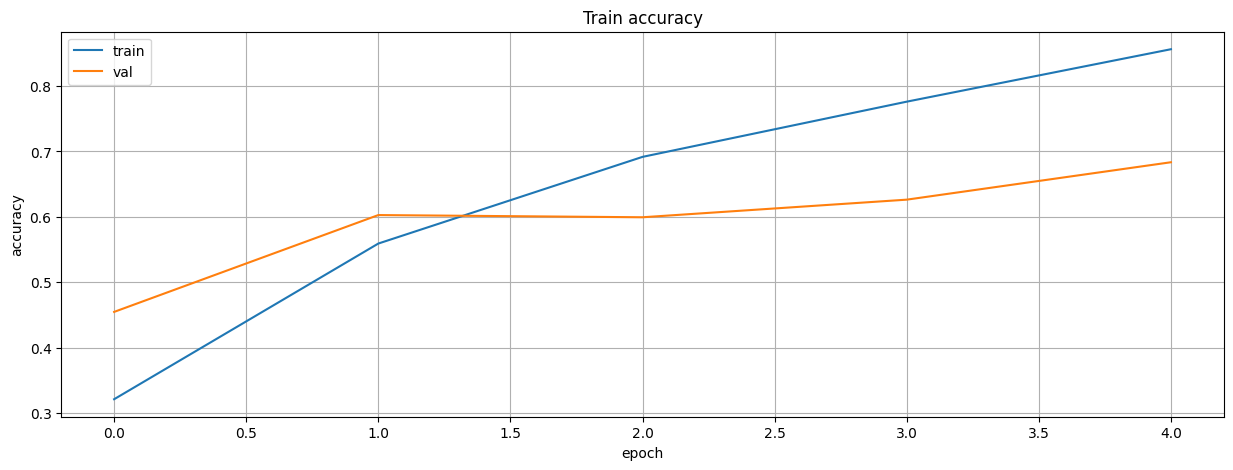

In [ ]:
# Summarize history for loss
plt.figure(figsize=(15,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Train loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.grid()
plt.show()

# Summarize history for accuracy
plt.figure(figsize=(15,5))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Train accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid()
plt.show()

#8. Grad-CAM for CNN

In [ ]:
n = 5  # Number of images to visualize
samples = x_test[:n]
y_pred = model.predict(samples)

def compute_gradcam(model, img_array, layer_name, class_index):
    """
    Compute Grad-CAM for a specific class index in an image array.

    Args:
    - model: The pre-trained model (after training).
    - img_array: The preprocessed input image.
    - layer_name: The name of the last convolutional layer.
    - class_index: The index of the class for which Grad-CAM should be computed.

    Returns:
    - The heatmap image overlaid on the original image.
    """
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(layer_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, class_index]

    # Compute gradients with respect to the last convolutional layer
    grads = tape.gradient(loss, conv_outputs)[0]

    # Global average pooling to get the weights of the neurons
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiply each channel by its weight
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1).numpy()
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)

    # Resize heatmap to the size of the original image
    heatmap = cv2.resize(heatmap, (img_array.shape[1], img_array.shape[2]))
    heatmap = np.uint8(255 * heatmap)

    # Convert heatmap to RGB
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Superimpose heatmap on original image
    superimposed_img = cv2.addWeighted(np.uint8(255 * img_array[0]), 0.6, heatmap, 0.4, 0)

    return superimposed_img

1/1 [==============================] - 2s 2s/step


In [ ]:
def visualize_gradcam(model, img_array, true_label, predicted_label, class_index, layer_name):
    """
    Visualize Grad-CAM heatmap for a specific image and class index.

    Args:
    - model: The pre-trained model (after training).
    - img_array: The preprocessed input image array.
    - true_label: The true label of the image.
    - predicted_label: The predicted label of the image.
    - class_index: The index of the class for which Grad-CAM should be computed.
    - layer_name: The name of the last convolutional layer.
    """
    heatmap = compute_gradcam(model, img_array, layer_name, class_index)

    # Plotting
    plt.figure(figsize=(6, 3))
    plt.subplot(1, 2, 1)
    plt.imshow(np.uint8(255 * img_array[0]))
    plt.title(f"True label: {true_label}, Predicted label: {predicted_label}")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(heatmap)
    plt.title('Grad-CAM')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

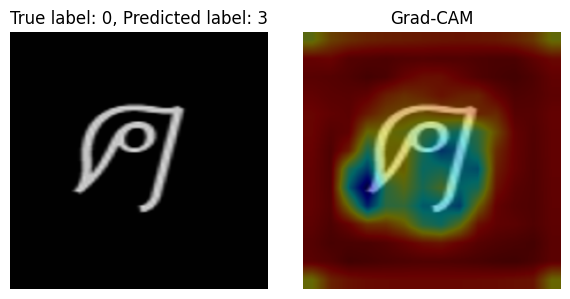

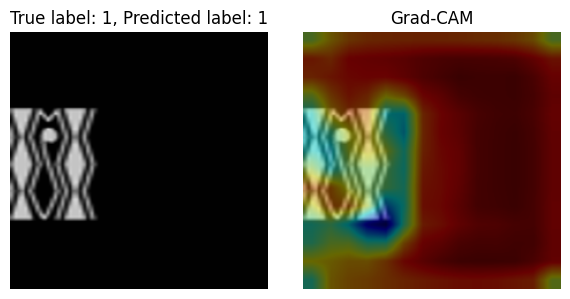

<ipython-input-17-6381fdc58797>:33: RuntimeWarning: divide by zero encountered in divide
  heatmap /= np.max(heatmap)
<ipython-input-17-6381fdc58797>:33: RuntimeWarning: invalid value encountered in divide
  heatmap /= np.max(heatmap)
<ipython-input-17-6381fdc58797>:37: RuntimeWarning: invalid value encountered in cast
  heatmap = np.uint8(255 * heatmap)


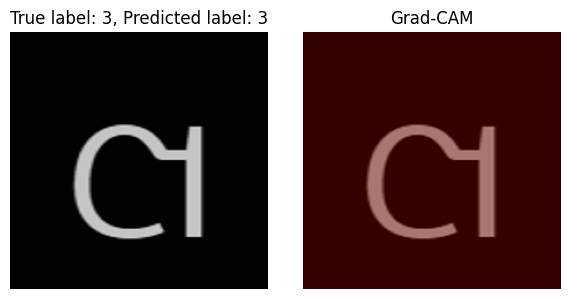

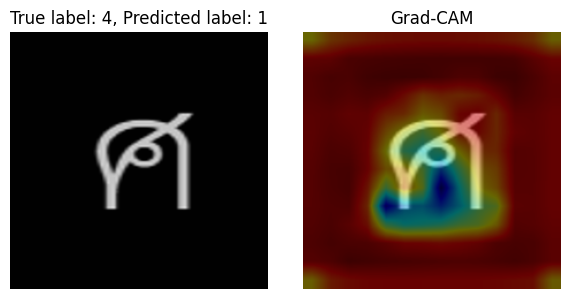

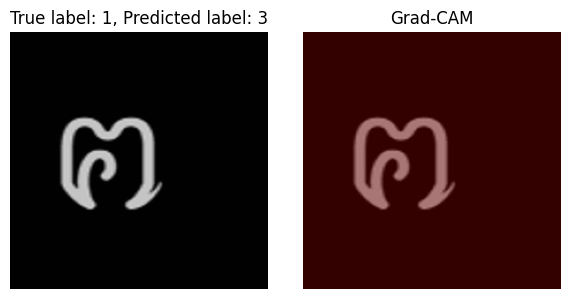

In [ ]:
for i in range(n):
    img_array = np.expand_dims(samples[i], axis=0)
    true_label = y_test[i]
    predicted_label = np.argmax(y_pred[i])
    class_index = predicted_label  # You can choose the class index to visualize (e.g., predicted_label)
    layer_name = 'block5_conv3'  # Name of the last convolutional layer

    visualize_gradcam(model, img_array, true_label, predicted_label, class_index, layer_name)

In [ ]:
# Evaluate the trained model on the test set
results = model.evaluate(x_test_vgg, y_test, batch_size=128)
print( f"{model.metrics_names}: {results}" )

3/3 [==============================] - 19s 9s/step - loss: 0.7989 - acc: 0.7251
['loss', 'acc']: [0.7989339828491211, 0.7250673770904541]


#10. Evaluate the model on test set

3/3 [==============================] - 1s 429ms/step - loss: 0.7989 - acc: 0.7251
['loss', 'acc']: [0.7989339828491211, 0.7250673770904541]
12/12 [==============================] - 6s 522ms/step
Confusion Matrix:
[[53  5 15  2  1]
 [ 7 55  0 15  0]
 [10  3 54  4  1]
 [ 0 25  2 40  0]
 [ 4  5  2  1 67]]
Accuracy: 0.7251
Precision: 0.7363
Recall: 0.7251
F1 Score: 0.7284


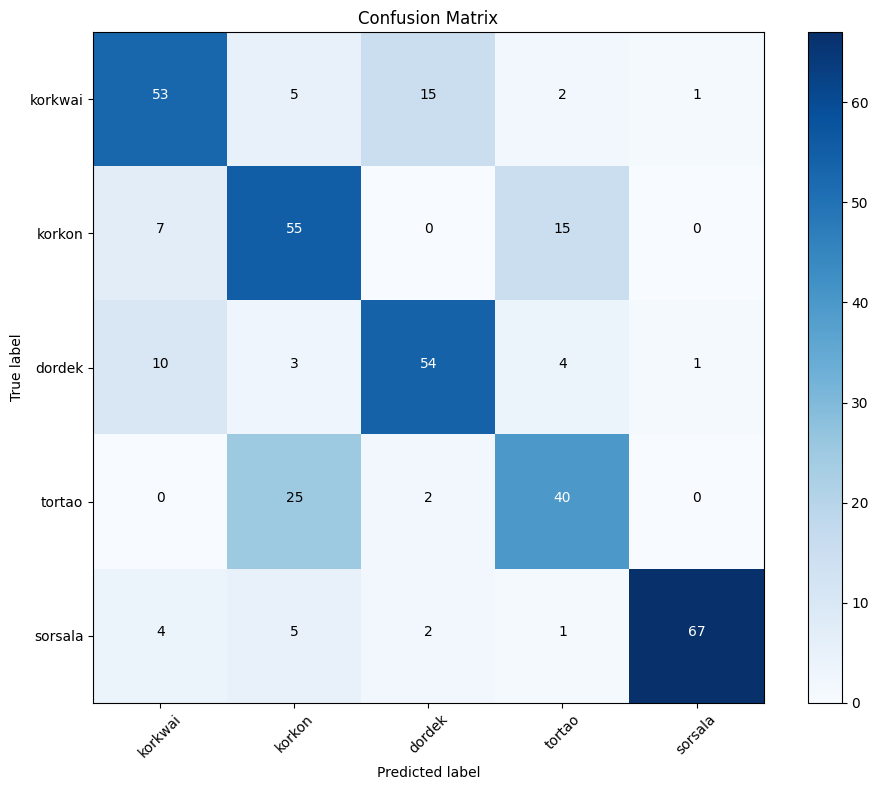

In [ ]:
results = model.evaluate(x_test_vgg, y_test, batch_size=128)
print(f"{model.metrics_names}: {results}")

# Predict on the full test set
y_pred_full = model.predict(x_test_vgg)
predicted_labels = np.argmax(y_pred_full, axis=1)

# Calculate confusion matrix
cm = confusion_matrix(y_test, predicted_labels)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, predicted_labels)
precision = precision_score(y_test, predicted_labels, average='weighted')
recall = recall_score(y_test, predicted_labels, average='weighted')
f1 = f1_score(y_test, predicted_labels, average='weighted')

# Print results
print("Confusion Matrix:")
print(cm)
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Plot confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(collected_labels))
plt.xticks(tick_marks, collected_labels, rotation=45)
plt.yticks(tick_marks, collected_labels)

# Add labels to the confusion matrix plot
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

#9. Inference

In [ ]:
# (Optional) Codes for coloring frames of the predicted images
plt.rcParams["axes.linewidth"] = 5

def color_frame( ax, y_true, y_pred ):
  # Green frame means correct prediction. Red frame means incorrect prediction.
  color = 'green' if (y_true == y_pred) else 'red'
  ax.spines['bottom'].set_color(color)
  ax.spines['top'].set_color(color)
  ax.spines['right'].set_color(color)
  ax.spines['left'].set_color(color)

samples.shape=(10, 224, 224, 3)
1/1 [==============================] - 3s 3s/step


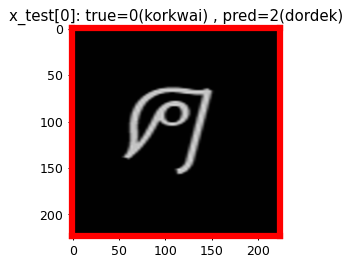

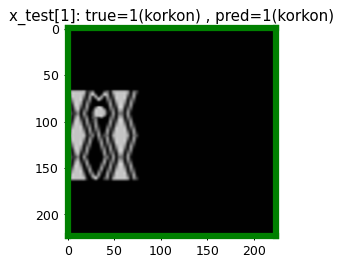

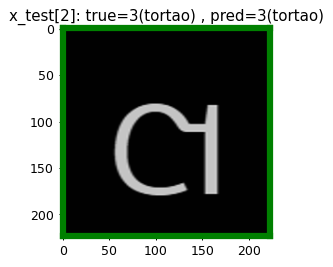

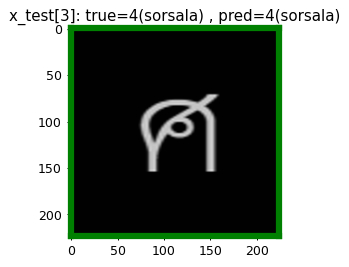

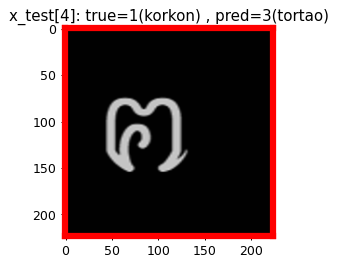

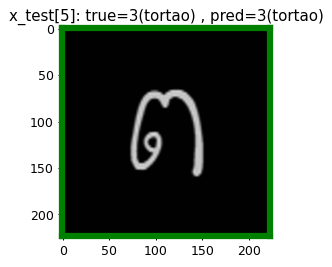

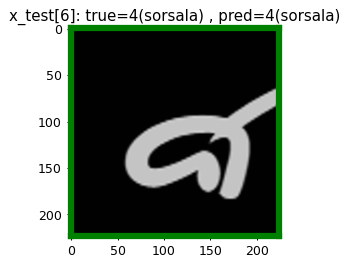

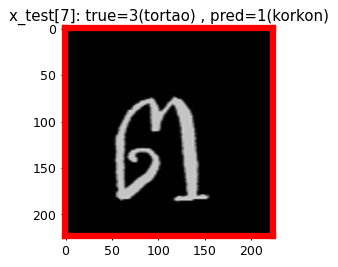

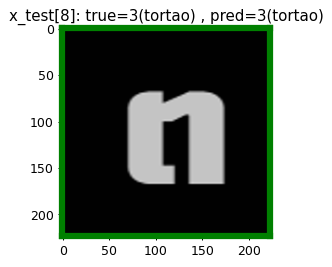

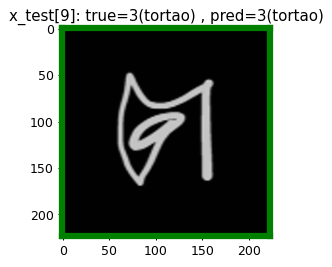

In [ ]:
# Assuming x_test is in [0, 1] range, scale to [0, 255]
x_test_display = (x_test * 255).astype(np.uint8)

n = 10
samples = x_test_vgg[:n]
print(f'{samples.shape=}')

# Predict a batch of samples
y_pred = model.predict(samples)

for i in range(n):
    plt.figure(figsize=(3, 3), dpi=90)
    ax = plt.gca()
    plt.imshow(x_test_display[i])
    true_label = y_test[i]
    pred_label = np.argmax(y_pred[i])
    plt.title(f"x_test[{i}]: true={true_label}({collected_labels[true_label]}) , pred={pred_label}({collected_labels[pred_label]})")
    color_frame(ax, true_label, pred_label)
    plt.show()

# check collected_labels = ['korkwai', 'korkon', 'dordek', 'tortao', 'sorsala']